# MRI Brain Tumor Segmentation with U-Net (Scratch vs. Pretrained)

This notebook presents an end-to-end pipeline for 1-channel MRI tumor segmentation. The dataset is split into **80/10/10** (train/val/test), masks are generated from VIA annotations and targeted augmentation is applied before training. A custom U-Net (from scratch) and a **ResNet-34–based U-Net** pre-initialized on ImageNet are trained with **Focal + Dice**. The performance is reported with **Dice** and **IoU** and illustrated via qualitative overlays. Results contrast scratch and pretrained setups and highlight domain-gap effects with plots and checkpoints saved for reproducibility.

## Imports

In [ ]:
# standard libraries
import os
import shutil
import json
import random
from pathlib import Path

# third-party libraries
import cv2
import torch
import kagglehub
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import albumentations as A
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image, ImageDraw
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader


# local scripts
from scripts.split_dataset_images import split_size_bucket_then_split
from scripts.tumor_size_distribution import plot_tumor_size_distribution
from scripts.generate_masks import build_all_masks
from scripts.loss_curve import plot_histories
from scripts.segmentation_results import report

## Download data set from Kaggle

In [ ]:
# download the dataset from Kaggle
path = kagglehub.dataset_download("ahmedhamada0/brain-tumor-detection")

# determine cache path (kagglehub stores in the ~/.cache folder by default)
src_path = os.path.expanduser("~/.cache/kagglehub/datasets/ahmedhamada0/brain-tumor-detection/versions/12")
dst_path = "./brain_tumor_dataset"

# copy data to the project directory
if not os.path.exists(dst_path):
    shutil.copytree(src_path, dst_path)
    print("Data has been copied to your project directory.")
else:
    print("The destination folder already exists.")

## Visualize and analyze dataset

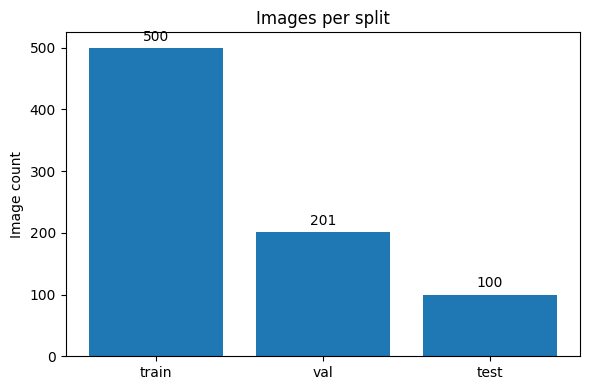

In [ ]:
base_dir = Path("brain_tumor_dataset/Br35H-Mask-RCNN")
splits   = ["train", "val", "test"]
exts     = {".jpg", ".jpeg", ".png", ".bmp"}

counts = []
labels = []

# Check each split directory for images and annotations
for s in splits:
    split_dir = base_dir / s
    imgs = [p for p in split_dir.rglob("*") if p.suffix.lower() in exts]
    n_imgs = len(imgs)

    ann_file = split_dir / f"annotations_{s}.json"
    if ann_file.exists():
        with ann_file.open("r", encoding="utf-8") as f:
            data = json.load(f)
        recs = [v for v in data.values() if "filename" in v]
        pos  = sum(1 for r in recs if r.get("regions"))
        counts.append(pos)
        labels.append(s)
        if pos != len(recs):
            print(f"Note: {s}: {pos}/{len(recs)} Entries with regions.")
    else:
        counts.append(n_imgs)
        labels.append(s)

# Plot the counts of images per split
plt.figure(figsize=(6,4))
bars = plt.bar(labels, counts)
plt.title("Images per split")
plt.ylabel("Image count")

try:
    plt.bar_label(bars, padding=3)
except Exception:
    for rect in bars:
        h = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., h, f"{int(h)}",
                 ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

***Conclusion***:\
The current splt is a bit unbalanced. To keep more data for learning and reduce overfitting the dataset will be re-split to 80/10/10 (train/val/test). 

In [ ]:
split_size_bucket_then_split(
    src_root="brain_tumor_dataset/Br35H-Mask-RCNN",
    json_paths=["brain_tumor_dataset/Br35H-Mask-RCNN/annotations_all.json"],
    out_root="brain_tumor_dataset/dataset",
    ratios=(0.8, 0.1, 0.1),
    q_small=0.50,
    q_large=0.90,
    train_boost_large=0.05,
    seed=42,
    buckets_debug_root="brain_tumor_dataset/buckets_audit" 
)

Buckets (<= 5043 = small, > 14907 = large):
  small : 401
  medium: 320
  large : 80
train | total  645  | small  321  medium  256  large   68  | thr_small 5043, thr_large 14907
val   | total   78  | small   40  medium   32  large    6  | thr_small 5043, thr_large 14907
test  | total   78  | small   40  medium   32  large    6  | thr_small 5043, thr_large 14907


### Tumor size distribution

train | total  645 | small 321 | medium 256 | large  68 (thr_small=5043, thr_large=14907)
val   | total   78 | small  40 | medium  32 | large   6 (thr_small=5043, thr_large=14907)
test  | total   78 | small  40 | medium  32 | large   6 (thr_small=5043, thr_large=14907)


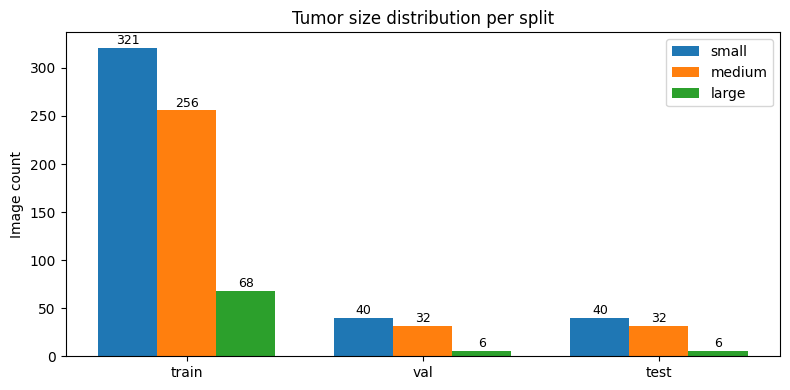

In [ ]:
plot_tumor_size_distribution(
    base_dir="brain_tumor_dataset/dataset",
    splits=("train","val","test"),
    thr_small=5043, thr_large=14907, 
    mode="grouped"
)

***Conclusion***:\
The split was performed with size-aware stratification so train/val/test each include small, medium and large tumors. In the dataset small tumors are over-represented, which is actually helpful for training because these are the hardest cases. The key is that validation and test still contain a representative share of large tumors. So the model can ensure to performs well across all tumor sizes.

Possible measures
- Augmentation for a larger dataset.
- Loss re-weighting (e.g. Dice/Focal variants) to emphasize small structures.

## MRI images with ground truth mask (purple overlay)

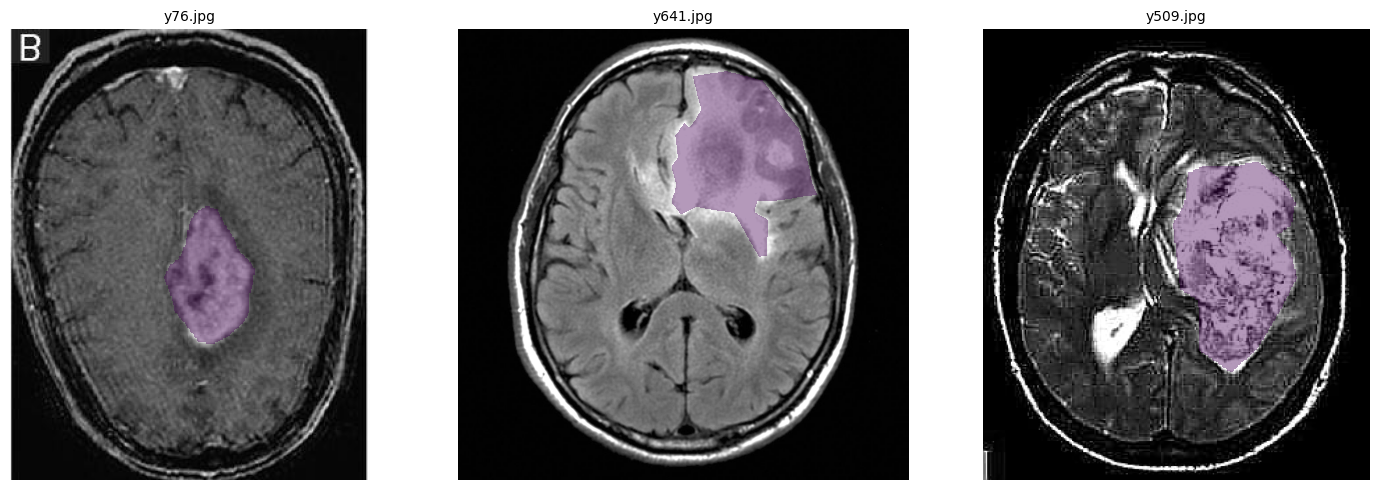

In [ ]:
# define dataset root and split
base_dir = Path("brain_tumor_dataset/dataset")
split = "val"
ann_path = base_dir / split / f"annotations.json"
split_dir = base_dir / split

# load annotations (VIA format)
with open(ann_path, "r", encoding="utf-8") as f:
    anns = json.load(f)

# build binary mask from regions (polygons + ellipses)
def regions_to_mask(h, w, regions):
    mask = Image.new("L", (w, h), 0)
    draw = ImageDraw.Draw(mask)
    for r in regions:
        sa = r.get("shape_attributes", {})
        name = sa.get("name")
        if name == "polygon":
            xs = sa.get("all_points_x", [])
            ys = sa.get("all_points_y", [])
            if xs and ys and len(xs) == len(ys):
                draw.polygon(list(zip(xs, ys)), outline=1, fill=1)
        elif name == "ellipse":
            cx = sa.get("cx"); cy = sa.get("cy")
            rx = sa.get("rx"); ry = sa.get("ry")
            theta = sa.get("theta", 0.0) or 0.0
            # approximate ellipse by polygon
            pts = []
            for k in range(120):
                t = 2*np.pi*k/120.0
                x = rx*np.cos(t); y = ry*np.sin(t)
                xr = x*np.cos(theta) - y*np.sin(theta)
                yr = x*np.sin(theta) + y*np.cos(theta)
                pts.append((cx + xr, cy + yr))
            draw.polygon(pts, outline=1, fill=1)
    return np.array(mask, dtype=np.uint8)

# collect candidates (resolve image path by filename)
candidates = []
for _, rec in anns.items():
    filename = rec.get("filename")
    if not filename:
        continue
    img_path = next(iter(split_dir.rglob(filename)), None)
    if img_path and img_path.exists():
        candidates.append((img_path, rec.get("regions", [])))

# sample and plot
k = min(3, len(candidates))
assert k > 0, "no images found for overlay"
sample = random.sample(candidates, k)

fig, axes = plt.subplots(1, k, figsize=(5*k, 5))
if k == 1:
    axes = [axes]

for ax, (img_path, regions) in zip(axes, sample):
    img = Image.open(img_path).convert("L")
    h, w = np.asarray(img).shape
    mask = regions_to_mask(h, w, regions)

    # show grayscale image
    ax.imshow(img, cmap="gray")
    # overlay mask 
    ax.imshow(np.ma.masked_where(mask == 0, mask), alpha=0.4)
    ax.set_title(img_path.name, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

## Building Masks
Binary masks are required for training since the segmentation network learns from image–mask pairs where the mask provides the per-pixel tumor labels.

In [ ]:
build_all_masks(
        root="brain_tumor_dataset/dataset",
        splits=("train","val","test"),
        ann_name="annotations.json",
        mask_subdir="masks",
        overwrite=False         # set to True to overwrite existing masks
        )

✔ train: saved 645 | skipped_exist 0 | missing_img 0
✔ val: saved 78 | skipped_exist 0 | missing_img 0
✔ test: saved 78 | skipped_exist 0 | missing_img 0
==> Total: saved 801 | skipped_exist 0 | missing_img 0


## Data-augmentation  
- only applied on the training dataset.  
- images and masks are transformed simultaneously to keep the annotations correct.  

-> generate mask images from annotations then augment image and mask together

In [ ]:
# Path definitions
train_dir = Path("brain_tumor_dataset/dataset/train")
ann_path = train_dir / "annotations.json"
mask_dir = train_dir / "masks"
mask_dir.mkdir(exist_ok=True, parents=True)


# build binary mask from regions (polygon + ellipse)
def regions_to_mask(h, w, regions):
    mask = Image.new("L", (w, h), 0)
    draw = ImageDraw.Draw(mask)
    for r in regions:
        sa = r.get("shape_attributes", {})
        name = sa.get("name")
        if name == "polygon":
            xs, ys = sa.get("all_points_x", []), sa.get("all_points_y", [])
            if xs and ys and len(xs) == len(ys):
                draw.polygon(list(zip(xs, ys)), outline=1, fill=1)
        elif name == "ellipse":
            cx, cy = sa.get("cx"), sa.get("cy")
            rx, ry = sa.get("rx"), sa.get("ry")
            theta = sa.get("theta", 0.0) or 0.0
            pts = []
            for k in range(120):
                t = 2*np.pi*k/120.0
                x = rx*np.cos(t); y = ry*np.sin(t)
                xr = x*np.cos(theta) - y*np.sin(theta)
                yr = x*np.sin(theta) + y*np.cos(theta)
                pts.append((cx + xr, cy + yr))
            draw.polygon(pts, outline=1, fill=1)
    return np.array(mask, dtype=np.uint8)


# export masks for all annotated images
def export_masks(split_dir, ann_file, mask_dir):
    with open(ann_file, "r", encoding="utf-8") as f:
        anns = json.load(f)
    for _, rec in anns.items():
        filename = rec.get("filename")
        if not filename:
            continue
        img_path = next(iter(split_dir.rglob(filename)), None)
        if not img_path or not img_path.exists():
            continue
        img = Image.open(img_path).convert("L")
        h, w = np.asarray(img).shape
        mask = regions_to_mask(h, w, rec.get("regions", []))
        Image.fromarray(mask*255).save(mask_dir / (Path(filename).stem + ".png"))


# define augmentation pipeline
def get_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.05,
            scale_limit=0.10,
            rotate_limit=12,
            border_mode=cv2.BORDER_REFLECT_101,
            p=0.7
        ),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=1.0),
            A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=1.0),
            A.RandomGamma(gamma_limit=(80,120), p=1.0),
        ], p=0.6),
        A.OneOf([
            A.GaussNoise(var_limit=(10.0, 40.0), p=1.0),
            A.GaussianBlur(blur_limit=(3,5), p=1.0),
        ], p=0.3),
        A.ElasticTransform(alpha=10, sigma=4, p=0.15),
        A.GridDistortion(num_steps=5, distort_limit=0.2, p=0.15),
    ])


# augmented training images + masks
def train_augmentation_seg(train_img_dir, train_mask_dir, augment_factor=0.3, seed=42):
    random.seed(seed)
    np.random.seed(seed)

    img_dir = Path(train_img_dir)
    m_dir = Path(train_mask_dir)

    exts = ("*.jpg", "*.jpeg", "*.png", "*.bmp")
    images = []
    for e in exts:
        images.extend(img_dir.glob(e))

    images = [p for p in images if (m_dir / (p.stem + ".png")).exists()]
    num_original = len(images)
    num_to_generate = int(num_original * augment_factor)

    transform = get_transform()

    for i in range(num_to_generate):
        img_path = random.choice(images)
        mask_path = m_dir / (img_path.stem + ".png")

        image = np.array(Image.open(img_path).convert("L"))  # grayscale
        mask = np.array(Image.open(mask_path).convert("L"))

        # a channel must be added for albumations.
        image = np.expand_dims(image, axis=-1)
        augmented = transform(image=image, mask=mask)
        aug_img, aug_mask = augmented["image"], augmented["mask"]

        # back to 2D grayscale image
        aug_img = np.squeeze(aug_img, axis=-1)

        new_name_img = f"aug_{i}_{img_path.stem}.png"
        new_name_msk = f"aug_{i}_{img_path.stem}.png"

        Image.fromarray(aug_img).save(img_dir / new_name_img)
        Image.fromarray(aug_mask).save(m_dir / new_name_msk)


# first export masks then augment
export_masks(train_dir, ann_path, mask_dir)
train_augmentation_seg(train_dir, mask_dir, augment_factor=0.45)

## U-Net for Brain Tumor Segmentation

A compact U-Net developed for grayscale MRI (1 channel, 256×256) to predict a binary tumor mask.

***Architecture***

- Encoder (downsampling): 4 stages with channels 64 → 128 → 256 → 512, each followed by MaxPool 2×2.

- Bottleneck: 1024 channels.

- Decoder (upsampling): 4 stages with Transposed Conv (↑2) skip-connection concat, then a conv block; channels 512 → 256 → 128 → 64.

- Output: 1×1 Conv → Sigmoid (probability map for tumor).

***Building Block (DoubleConv)***

- (Conv 3×3 → BatchNorm → ReLU) × 2

***Input / Output***

- Input: N × 1 × 256 × 256 MRI slice

- Output: N × 1 × 256 × 256 tumor probability map (thresholded for mask)

***Idea***

- Downsample for context and upsample with skip connections for precise localization.

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        self.enc1 = DoubleConv(1, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(128, 64)
        self.out_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b  = self.bottleneck(self.pool(e4))
        d1 = self.up1(b); d1 = torch.cat([d1, e4], dim=1); d1 = self.dec1(d1)
        d2 = self.up2(d1); d2 = torch.cat([d2, e3], dim=1); d2 = self.dec2(d2)
        d3 = self.up3(d2); d3 = torch.cat([d3, e2], dim=1); d3 = self.dec3(d3)
        d4 = self.up4(d3); d4 = torch.cat([d4, e1], dim=1); d4 = self.dec4(d4)
        return torch.sigmoid(self.out_conv(d4))

## Data-preperation
Grayscale MRIs are paired with binary masks. Both are resized to 256×256 and returned as tensors (image 1×H×W in [0,1], mask 1×H×W in {0,1}). Split by train/val/test folders with batch_size=4 (shuffle only for train).

In [ ]:
# Define the dataset class for segmentation tasks
class SegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir)
        self.images = sorted([f for f in self.img_dir.glob("*.jpg")])
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.mask_dir / (img_path.stem + ".png")

        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        image = np.array(image)[..., None]
        mask   = np.array(mask, dtype=np.float32)
        mask[mask > 0] = 1.0


        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image = aug["image"]
            mask = aug["mask"]

        image = torch.from_numpy(image).permute(2,0,1).float() / 255.0
        mask = torch.from_numpy(mask).unsqueeze(0).float()

        return image, mask

transform = A.Compose([
    A.Resize(256, 256)
])

train_ds = SegDataset(
    img_dir="brain_tumor_dataset/dataset/train",
    mask_dir="brain_tumor_dataset/dataset/train/masks",
    transform=transform
)
val_ds = SegDataset(
    img_dir="brain_tumor_dataset/dataset/val",
    mask_dir="brain_tumor_dataset/dataset/val/masks",
    transform=transform
)
test_ds = SegDataset(
    img_dir="brain_tumor_dataset/dataset/test",
    mask_dir="brain_tumor_dataset/dataset/test/masks",
    transform=transform
)

# Create DataLoaders for each dataset
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False)

c:\Users\Saniye\anaconda3\envs\Masterarbeit_Verzweiflung\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Training-Loop
Training loop uses Focal + Dice to optimize a U-Net (custom or the SMP variant). Each epoch prints train/val loss and Dice. On any validation-Dice improvement it saves best.pth and writes last.pth after the final epoch. Early stopping triggers after patience epochs without gains. All curves and metadata go to training_metrics.json. Dice measures overlap between prediction and ground truth.

In [ ]:
# Define the Focal Loss and Focal Dice Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha, self.gamma, self.reduction = alpha, gamma, reduction
    def forward(self, inputs, targets):
        bce = F.binary_cross_entropy(inputs, targets, reduction="none")
        pt  = torch.exp(-bce)
        loss = self.alpha * (1-pt)**self.gamma * bce
        return loss.mean() if self.reduction=="mean" else loss.sum()

class FocalDiceLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, dice_weight=0.5):
        super().__init__()
        self.focal = FocalLoss(alpha=alpha, gamma=gamma)
        self.dw = dice_weight
    def dice_loss(self, probs, targets, eps=1e-6):
        num = 2*(probs*targets).sum(dim=(1,2,3))
        den = probs.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) + eps
        return 1.0 - (num/den).mean()
    def forward(self, inputs, targets):
        return (1-self.dw)*self.focal(inputs, targets) + self.dw*self.dice_loss(inputs, targets)

def dice_bin(p, y, thr=0.5, eps=1e-6):
    p = (p > thr).float()
    num = 2*(p*y).sum(dim=(1,2,3))
    den = p.sum(dim=(1,2,3)) + y.sum(dim=(1,2,3)) + eps
    return (num/den).mean().item()


# Train the UNet model with Focal Dice Loss
def train_unet_focaldice_safe(model, train_loader, val_loader, epochs=20, lr=1e-4, weight_decay=1e-4,
                              patience=5, alpha=0.75, gamma=2.0, dice_weight=0.5,
                              save_dir="models", prefer_cuda=True, disable_cudnn=False,
                              run_name="", epoch_offset=0):

    if disable_cudnn:
        torch.backends.cudnn.enabled = False
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    device = torch.device("cuda" if (prefer_cuda and torch.cuda.is_available()) else "cpu")
    try:
        model = model.to(device)
        _ = model(torch.randn(1,1,256,256, device=device)).sum().item()
    except Exception as e:
        print("GPU problem -> fallback CPU:", repr(e))
        try: torch.cuda.empty_cache()
        except: pass
        device = torch.device("cpu")
        model = model.to(device)

    crit = FocalDiceLoss(alpha=alpha, gamma=gamma, dice_weight=dice_weight)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    save_path = Path(save_dir); save_path.mkdir(parents=True, exist_ok=True)
    history = {"train_loss": [], "train_dice": [], "val_loss": [], "val_dice": [], "run_name": run_name}
    best_dice, best_epoch, best_state = -1.0, -1, None
    no_improve = 0
    prefix = f"{run_name}" if run_name else ""

    total_epochs = epoch_offset + epochs
    print(f"{prefix}Start | Epochen {epochs} | Device {device.type} | Save {save_path}")

    for ep in range(1, epochs+1):
        ep_global = epoch_offset + ep

        model.train()
        tr_loss, tr_dice, n = 0.0, 0.0, 0
        progress_bar = tqdm(train_loader, desc=f"{prefix}Epoch {ep_global}/{total_epochs}", leave=False)
        for x, y in progress_bar:
            x, y = x.to(device), y.to(device)
            p = model(x)
            loss = crit(p, y)
            opt.zero_grad(); loss.backward(); opt.step()

            bs = x.size(0)
            tr_loss += loss.item() * bs
            tr_dice += dice_bin(p, y) * bs
            n += bs
            progress_bar.set_postfix({'train_loss': f"{loss.item():.4f}"})

        tr_loss /= max(n, 1)
        tr_dice /= max(n, 1)

        model.eval()
        val_loss, val_dice, m = 0.0, 0.0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                p = model(x)
                loss = crit(p, y)
                bs = x.size(0)
                val_loss += loss.item() * bs
                val_dice += dice_bin(p, y) * bs
                m += bs
        val_loss /= max(m, 1)
        val_dice /= max(m, 1)

        history["train_loss"].append(tr_loss)
        history["train_dice"].append(tr_dice)
        history["val_loss"].append(val_loss)
        history["val_dice"].append(val_dice)

        print(f"{prefix}Epoch {ep_global}/{total_epochs}: "
              f"Train Loss: {tr_loss:.4f} | Train Dice: {tr_dice:.4f} || "
              f"Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")
        print("-" * 80)

        if val_dice > best_dice + 1e-6:
            best_dice, best_epoch, no_improve = val_dice, ep_global, 0
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            torch.save(best_state, save_path / "best.pth")
            print("💾 Saved the best model.")
        else:
            no_improve += 1
            print(f"⏳ No Progress (Counter: {no_improve}/{patience})")
            if no_improve >= patience:
                print(f"⏹️ Early stopping bei Epoche {ep_global}")
                break

    torch.save(model.state_dict(), save_path / "last.pth")
    with open(save_path / "training_metrics.json", "w", encoding="utf-8") as f:
        json.dump({**history, "best_epoch": best_epoch, "best_val_dice": best_dice}, f, indent=4)

    print(f"{prefix}End | Best Epoch {best_epoch} | Best Val Dice {best_dice:.4f} \n")
    return best_epoch, best_dice

In [ ]:
# Train the U-Net model
model = UNet()
best_epoch, best_dice = train_unet_focaldice_safe(
    model, train_loader, val_loader,
    epochs=30, lr=1e-4, patience=5,
    save_dir="models/models_unet_base", run_name="[SELFBUILD UNET]"
)

[SELFBUILD UNET]Start | Epochen 30 | Device cuda | Save models\models_unet_base


[SELFBUILD UNET]Epoch 1/30: Train Loss: 0.4393 | Train Dice: 0.4768 || Val Loss: 0.4175 | Val Dice: 0.5541
--------------------------------------------------------------------------------
💾 Saved the best model.


[SELFBUILD UNET]Epoch 2/30: Train Loss: 0.3922 | Train Dice: 0.5789 || Val Loss: 0.3588 | Val Dice: 0.6335
--------------------------------------------------------------------------------
💾 Saved the best model.


[SELFBUILD UNET]Epoch 3/30: Train Loss: 0.3369 | Train Dice: 0.6782 || Val Loss: 0.3112 | Val Dice: 0.7392
--------------------------------------------------------------------------------
💾 Saved the best model.


[SELFBUILD UNET]Epoch 4/30: Train Loss: 0.2858 | Train Dice: 0.7389 || Val Loss: 0.3150 | Val Dice: 0.5983
--------------------------------------------------------------------------------
⏳ No Progress (Counter: 1/5)


[SELFBUILD UNET]Epoch 5/30: Train Loss: 0.2394 | Train Dice: 0.7714 || Val Loss: 0.2199 | Val Dice: 0.7846
--------------------------------------------------------------------------------
💾 Saved the best model.


[SELFBUILD UNET]Epoch 6/30: Train Loss: 0.2001 | Train Dice: 0.8002 || Val Loss: 0.2042 | Val Dice: 0.7958
--------------------------------------------------------------------------------
💾 Saved the best model.


[SELFBUILD UNET]Epoch 7/30: Train Loss: 0.1638 | Train Dice: 0.8357 || Val Loss: 0.1435 | Val Dice: 0.8616
--------------------------------------------------------------------------------
💾 Saved the best model.


[SELFBUILD UNET]Epoch 8/30: Train Loss: 0.1357 | Train Dice: 0.8591 || Val Loss: 0.1419 | Val Dice: 0.8150
--------------------------------------------------------------------------------
⏳ No Progress (Counter: 1/5)


[SELFBUILD UNET]Epoch 9/30: Train Loss: 0.1373 | Train Dice: 0.8377 || Val Loss: 0.1176 | Val Dice: 0.8514
--------------------------------------------------------------------------------
⏳ No Progress (Counter: 2/5)


[SELFBUILD UNET]Epoch 10/30: Train Loss: 0.1171 | Train Dice: 0.8574 || Val Loss: 0.1309 | Val Dice: 0.8320
--------------------------------------------------------------------------------
⏳ No Progress (Counter: 3/5)


[SELFBUILD UNET]Epoch 11/30: Train Loss: 0.1028 | Train Dice: 0.8744 || Val Loss: 0.1196 | Val Dice: 0.8354
--------------------------------------------------------------------------------
⏳ No Progress (Counter: 4/5)


[SELFBUILD UNET]Epoch 12/30: Train Loss: 0.1004 | Train Dice: 0.8718 || Val Loss: 0.0909 | Val Dice: 0.8808
--------------------------------------------------------------------------------
💾 Saved the best model.


[SELFBUILD UNET]Epoch 13/30: Train Loss: 0.0857 | Train Dice: 0.8905 || Val Loss: 0.0836 | Val Dice: 0.8869
--------------------------------------------------------------------------------
💾 Saved the best model.


[SELFBUILD UNET]Epoch 14/30: Train Loss: 0.0870 | Train Dice: 0.8849 || Val Loss: 0.0886 | Val Dice: 0.8763
--------------------------------------------------------------------------------
⏳ No Progress (Counter: 1/5)


[SELFBUILD UNET]Epoch 15/30: Train Loss: 0.0784 | Train Dice: 0.8963 || Val Loss: 0.0701 | Val Dice: 0.9023
--------------------------------------------------------------------------------
💾 Saved the best model.


[SELFBUILD UNET]Epoch 16/30: Train Loss: 0.0718 | Train Dice: 0.9036 || Val Loss: 0.0662 | Val Dice: 0.9078
--------------------------------------------------------------------------------
💾 Saved the best model.


[SELFBUILD UNET]Epoch 17/30: Train Loss: 0.0705 | Train Dice: 0.9031 || Val Loss: 0.0688 | Val Dice: 0.9086
--------------------------------------------------------------------------------
💾 Saved the best model.


[SELFBUILD UNET]Epoch 18/30: Train Loss: 0.0758 | Train Dice: 0.8942 || Val Loss: 0.0741 | Val Dice: 0.8931
--------------------------------------------------------------------------------
⏳ No Progress (Counter: 1/5)


[SELFBUILD UNET]Epoch 19/30: Train Loss: 0.0701 | Train Dice: 0.9015 || Val Loss: 0.0730 | Val Dice: 0.8931
--------------------------------------------------------------------------------
⏳ No Progress (Counter: 2/5)


[SELFBUILD UNET]Epoch 20/30: Train Loss: 0.0689 | Train Dice: 0.9027 || Val Loss: 0.0873 | Val Dice: 0.8656
--------------------------------------------------------------------------------
⏳ No Progress (Counter: 3/5)


[SELFBUILD UNET]Epoch 21/30: Train Loss: 0.0672 | Train Dice: 0.9039 || Val Loss: 0.1048 | Val Dice: 0.8452
--------------------------------------------------------------------------------
⏳ No Progress (Counter: 4/5)


[SELFBUILD UNET]Epoch 22/30: Train Loss: 0.0637 | Train Dice: 0.9088 || Val Loss: 0.0662 | Val Dice: 0.9026
--------------------------------------------------------------------------------
⏳ No Progress (Counter: 5/5)
⏹️ Early stopping bei Epoche 22
[SELFBUILD UNET]End | Best Epoch 17 | Best Val Dice 0.9086 



## Loss Curve

Shows training vs. validation loss across epochs.

saved → reports\plots\unet_base_curves.png


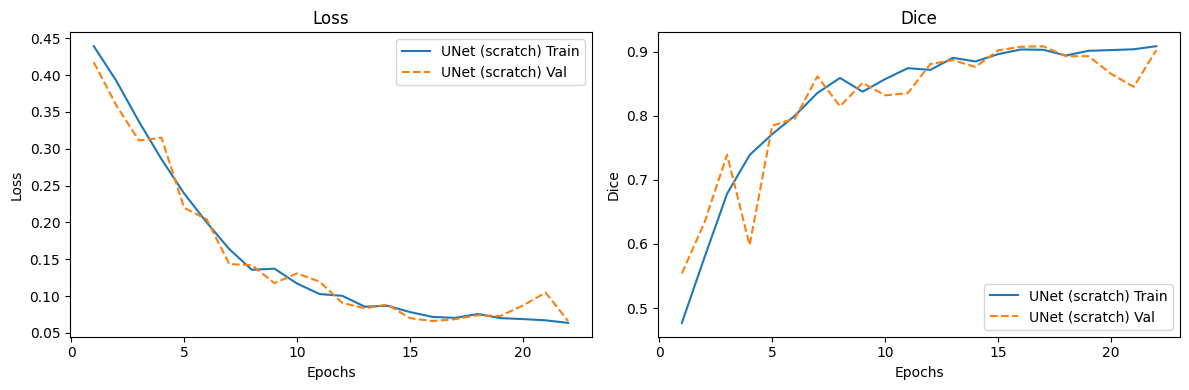

In [ ]:
plot_histories(
    ["models/models_unet_base/training_metrics.json"],
    labels=["UNet (scratch)"],
    save_dir="reports/plots",
    save_name="unet_base_curves.png"
)

***Conclusion***  
Training now looks stable: after moving away from the original Br35H-Mask-RCNN split that induced overfitting. The loss decreases steadily and the validation curve closely tracks the training curve. Dice rises and stabilizes near the training score with no obvious overfitting. 

## Visualizing Segmentation Results

This function overlays **ground truth** (purple) and **predicted** masks (light-blue) on the original grayscale MRI to visually inspect segmentation quality. It iterates over the test loader. After that it computes **Dice** and **IoU** per batch and prints their averages. 

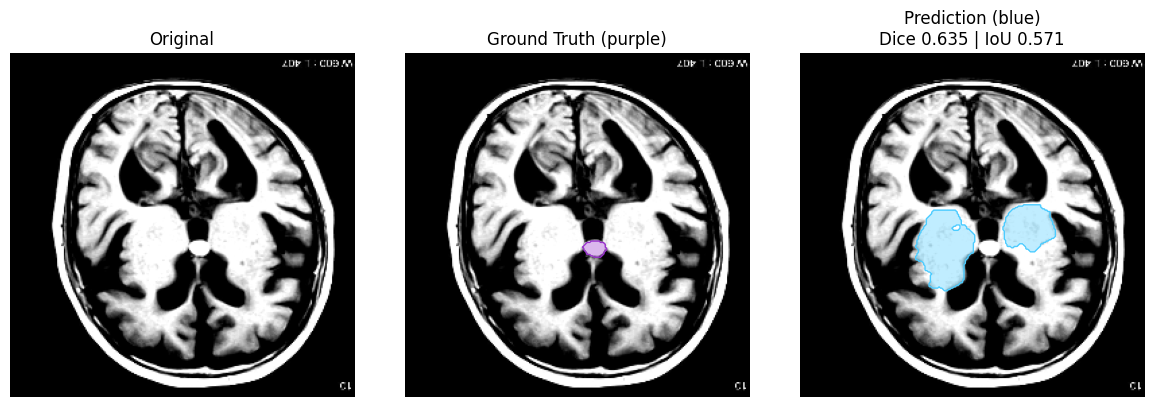

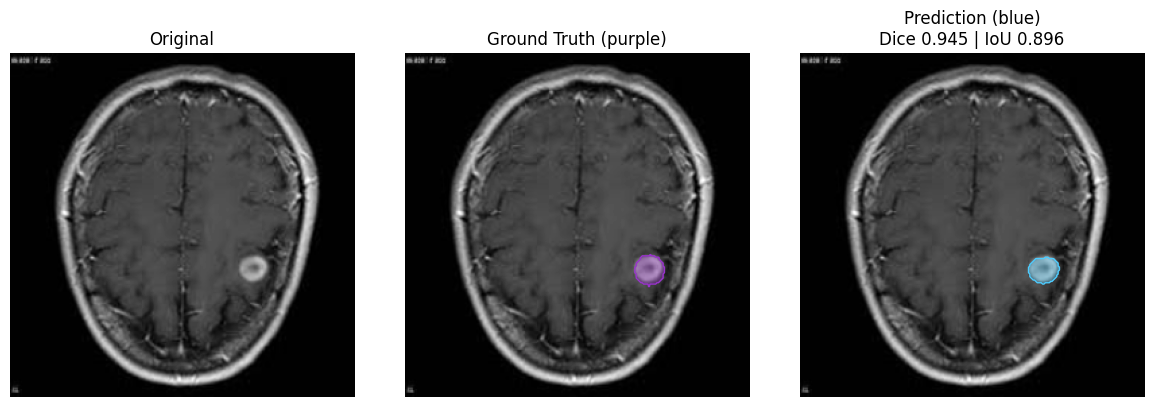

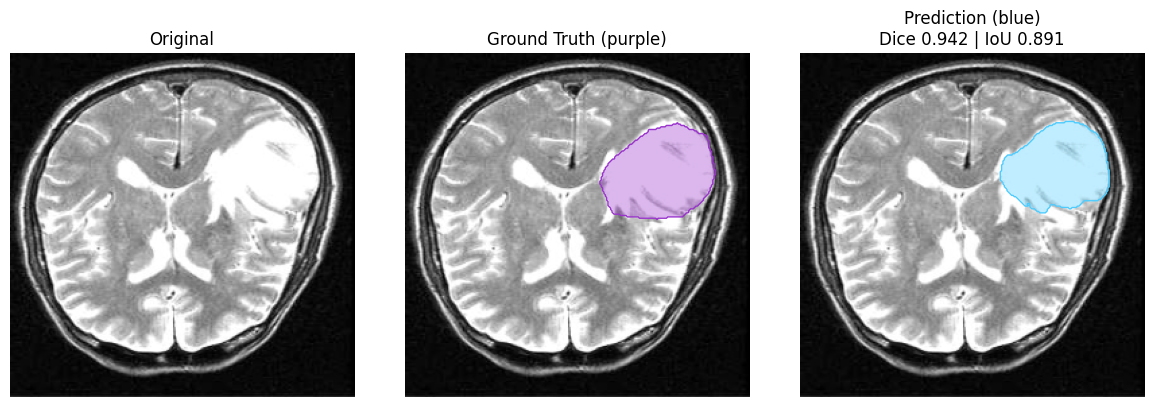

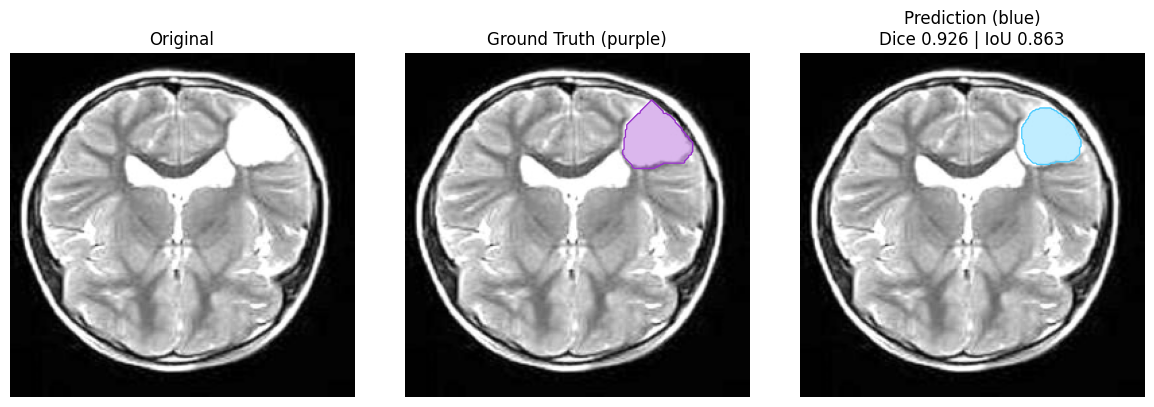

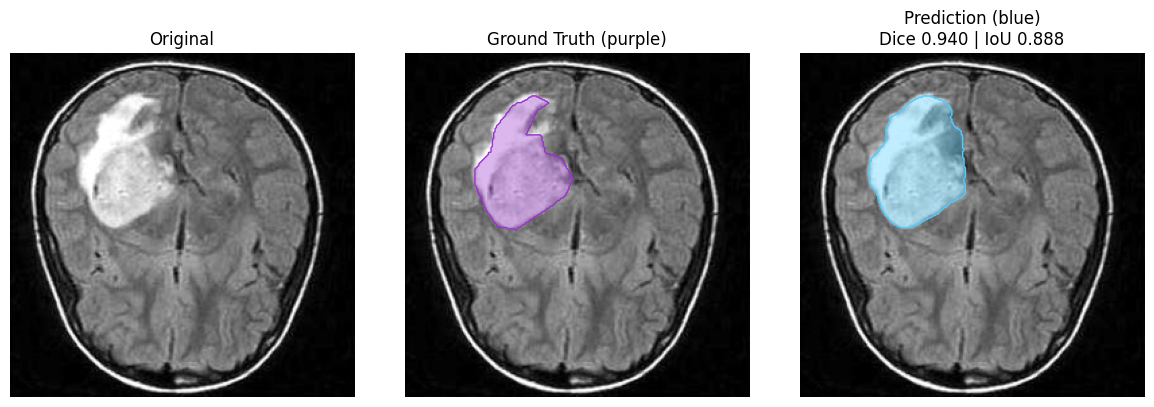

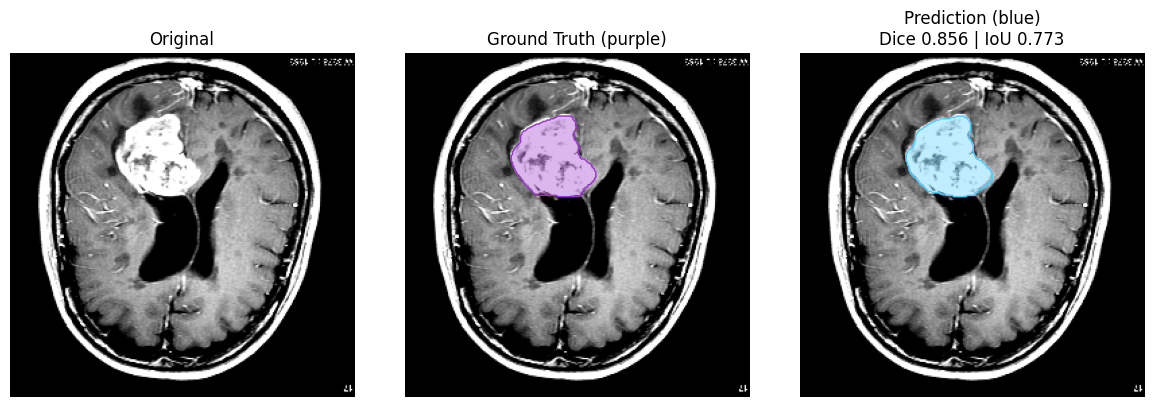

[unet_base] avg_dice 0.8739 | avg_iou 0.8140 → saved in reports\unet_base


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
m_self = UNet(n_classes=1).to(device)
m_self.load_state_dict(torch.load("models/models_unet_base/best.pth", map_location=device))
m_self.eval()

_ = report(m_self, test_loader, tag="unet_base", device=device, max_samples=6, thr=0.5)

## Pretrained Model Training

Pretrained U-Net (ResNet-34, 1-channel) trained in two phases: **warm-up** (encoder frozen) then **fine-tune** (encoder unfrozen) with **Focal + Dice**. Best checkpoints/metrics are saved to `models/models_smp_warmup/` and `models/models_smp_finetune/`.

In [ ]:
model_smp = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1, 
    classes=1,
    activation="sigmoid"
)

# Warm-up: froze Encoder
for p in model_smp.encoder.parameters():
    p.requires_grad = False

warmup_epochs = 5
best_epoch_warm, best_dice_warm = train_unet_focaldice_safe(
    model_smp, train_loader, val_loader,
    epochs=warmup_epochs, lr=1e-4, patience=3,
    save_dir="models/models_smp_warmup",
    run_name="[WARMUP] "
)

# Finetune: unfreeze Encoder
for p in model_smp.encoder.parameters():
    p.requires_grad = True

finetune_epochs = 30
best_epoch_ft, best_dice_ft = train_unet_focaldice_safe(
    model_smp, train_loader, val_loader,
    epochs=finetune_epochs, lr=1e-4, patience=6, weight_decay=1e-3,
    save_dir="models/models_smp_finetune",
    run_name="[FINETUNE] ",
    epoch_offset=warmup_epochs
)

[WARMUP] Start | Epochen 5 | Device cuda | Save models\models_smp_warmup


[WARMUP] Epoch 1/5: Train Loss: 0.5092 | Train Dice: 0.3254 || Val Loss: 0.4612 | Val Dice: 0.5341
--------------------------------------------------------------------------------
💾 Saved the best model.


[WARMUP] Epoch 2/5: Train Loss: 0.4074 | Train Dice: 0.6844 || Val Loss: 0.3832 | Val Dice: 0.6831
--------------------------------------------------------------------------------
💾 Saved the best model.


[WARMUP] Epoch 3/5: Train Loss: 0.3471 | Train Dice: 0.7739 || Val Loss: 0.3076 | Val Dice: 0.7923
--------------------------------------------------------------------------------
💾 Saved the best model.


[WARMUP] Epoch 4/5: Train Loss: 0.2758 | Train Dice: 0.8135 || Val Loss: 0.2346 | Val Dice: 0.8425
--------------------------------------------------------------------------------
💾 Saved the best model.


[WARMUP] Epoch 5/5: Train Loss: 0.2037 | Train Dice: 0.8536 || Val Loss: 0.1802 | Val Dice: 0.8647
--------------------------------------------------------------------------------
💾 Saved the best model.
[WARMUP] End | Best Epoch 5 | Best Val Dice 0.8647 

[FINETUNE] Start | Epochen 30 | Device cuda | Save models\models_smp_finetune


[FINETUNE] Epoch 6/35: Train Loss: 0.1646 | Train Dice: 0.8503 || Val Loss: 0.1303 | Val Dice: 0.8764
--------------------------------------------------------------------------------
💾 Saved the best model.


[FINETUNE] Epoch 7/35: Train Loss: 0.1119 | Train Dice: 0.8954 || Val Loss: 0.0890 | Val Dice: 0.9163
--------------------------------------------------------------------------------
💾 Saved the best model.


[FINETUNE] Epoch 8/35: Train Loss: 0.0850 | Train Dice: 0.9109 || Val Loss: 0.0695 | Val Dice: 0.9211
--------------------------------------------------------------------------------
💾 Saved the best model.


[FINETUNE] Epoch 9/35: Train Loss: 0.0758 | Train Dice: 0.9084 || Val Loss: 0.0626 | Val Dice: 0.9240
--------------------------------------------------------------------------------
💾 Saved the best model.


[FINETUNE] Epoch 10/35: Train Loss: 0.0658 | Train Dice: 0.9157 || Val Loss: 0.0715 | Val Dice: 0.9043
--------------------------------------------------------------------------------
⏳ No Progress (Counter: 1/6)


[FINETUNE] Epoch 11/35: Train Loss: 0.0587 | Train Dice: 0.9231 || Val Loss: 0.0585 | Val Dice: 0.9191
--------------------------------------------------------------------------------
⏳ No Progress (Counter: 2/6)


[FINETUNE] Epoch 12/35: Train Loss: 0.0579 | Train Dice: 0.9209 || Val Loss: 0.0641 | Val Dice: 0.9080
--------------------------------------------------------------------------------
⏳ No Progress (Counter: 3/6)


[FINETUNE] Epoch 13/35: Train Loss: 0.0537 | Train Dice: 0.9249 || Val Loss: 0.0579 | Val Dice: 0.9177
--------------------------------------------------------------------------------
⏳ No Progress (Counter: 4/6)


[FINETUNE] Epoch 14/35: Train Loss: 0.0473 | Train Dice: 0.9331 || Val Loss: 0.0587 | Val Dice: 0.9152
--------------------------------------------------------------------------------
⏳ No Progress (Counter: 5/6)


[FINETUNE] Epoch 15/35: Train Loss: 0.0439 | Train Dice: 0.9375 || Val Loss: 0.0549 | Val Dice: 0.9224
--------------------------------------------------------------------------------
⏳ No Progress (Counter: 6/6)
⏹️ Early stopping bei Epoche 15
[FINETUNE] End | Best Epoch 9 | Best Val Dice 0.9240 



## Loss Curve

saved → reports\plots\smp_finetune_curves.png


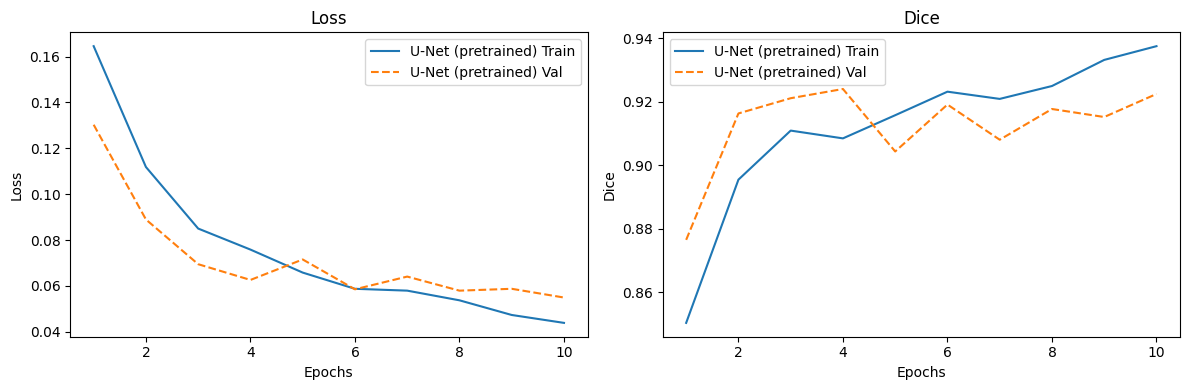

In [ ]:
plot_histories(
    ["models/models_smp_finetune/training_metrics.json"],
    labels=["U-Net (pretrained)"],
    save_dir="reports/plots",
    save_name="smp_finetune_curves.png"
)

***Conclusion***\
With stronger weight decay train and val losses fall together and Dice converges around ~0.92–0.94 with only a small gap signs of reduced overfitting.

## Visualization

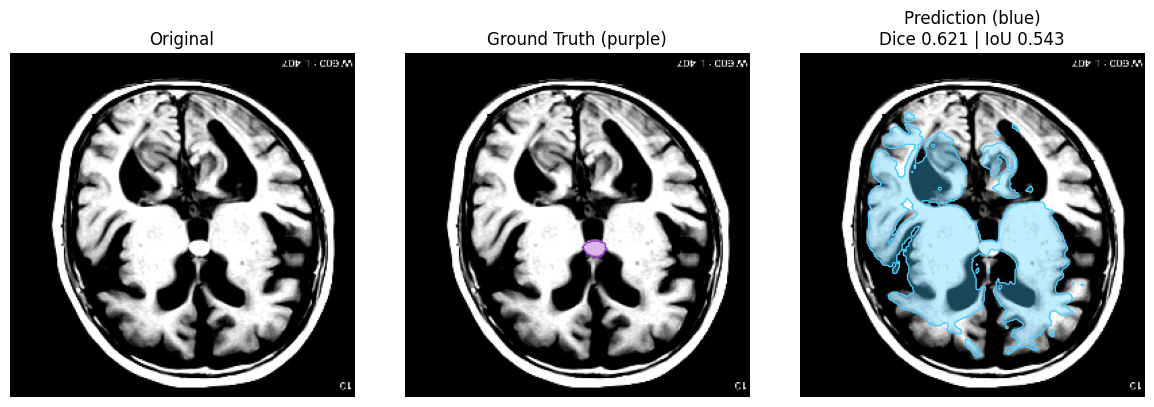

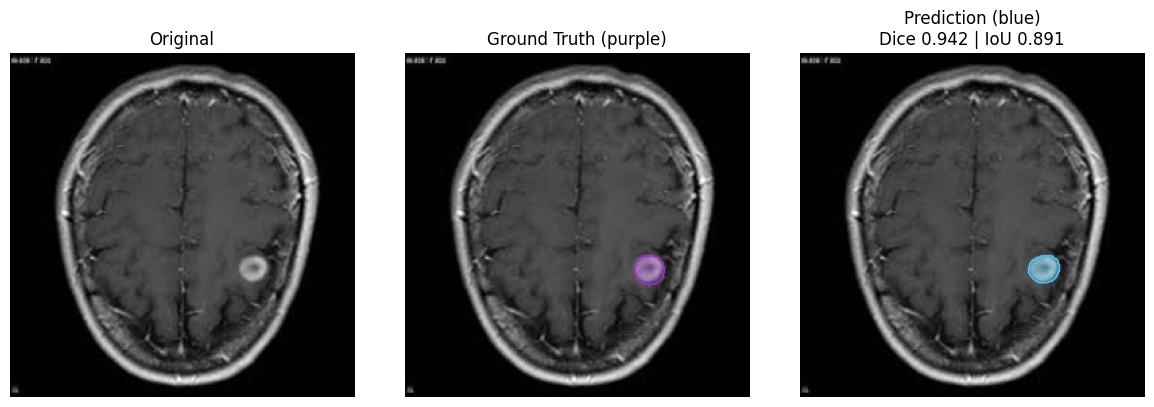

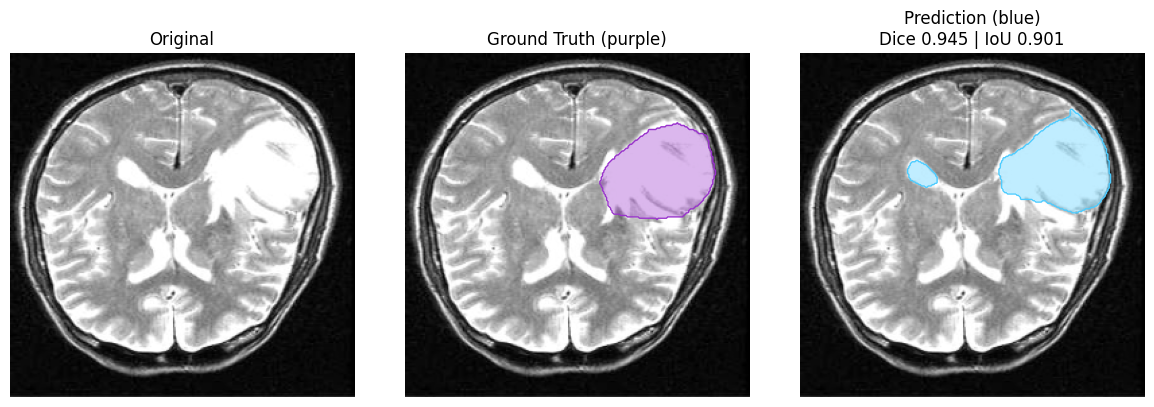

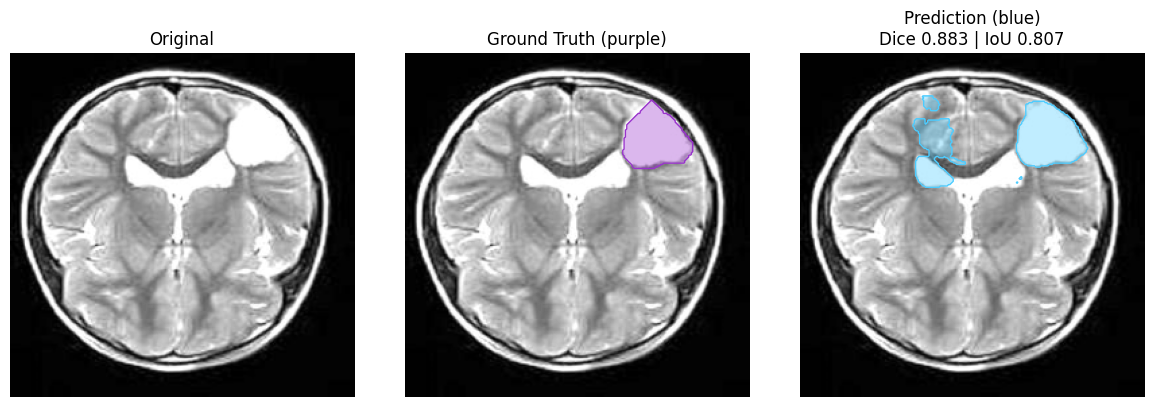

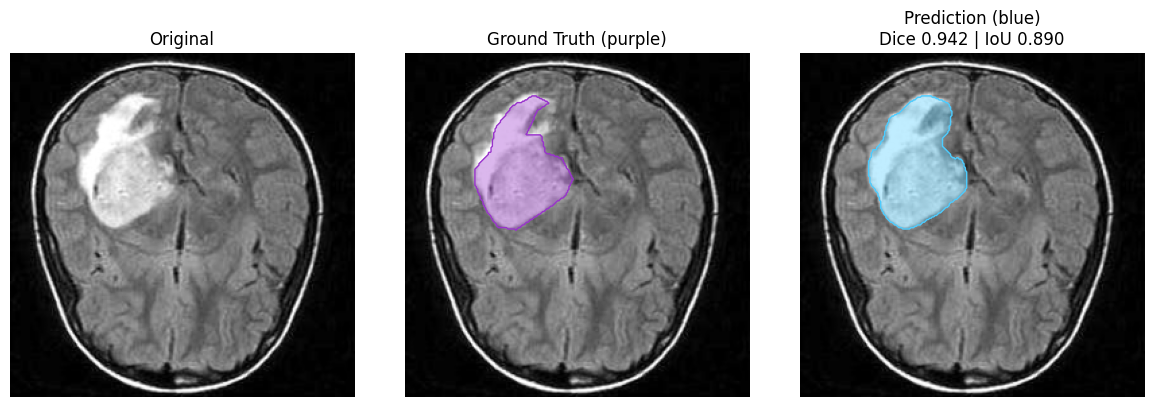

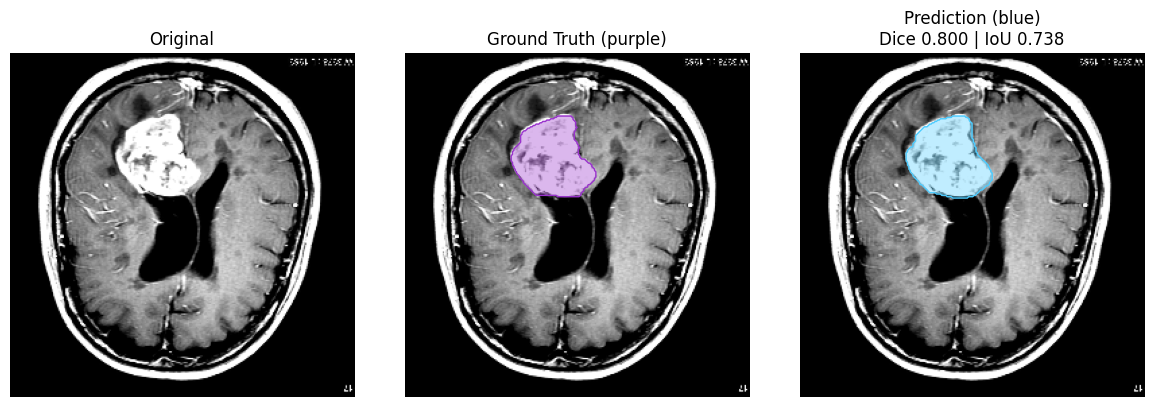

[smp_finetune] avg_dice 0.8554 | avg_iou 0.7949 → saved in reports\smp_finetune


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
m_smp = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=1, classes=1, activation="sigmoid").to(device)
m_smp.load_state_dict(torch.load("models/models_smp_finetune/best.pth", map_location=device))
m_smp.eval()

_ = report(m_smp, test_loader, tag="smp_finetune", device=device, max_samples=6, thr=0.5)

## Result Summary

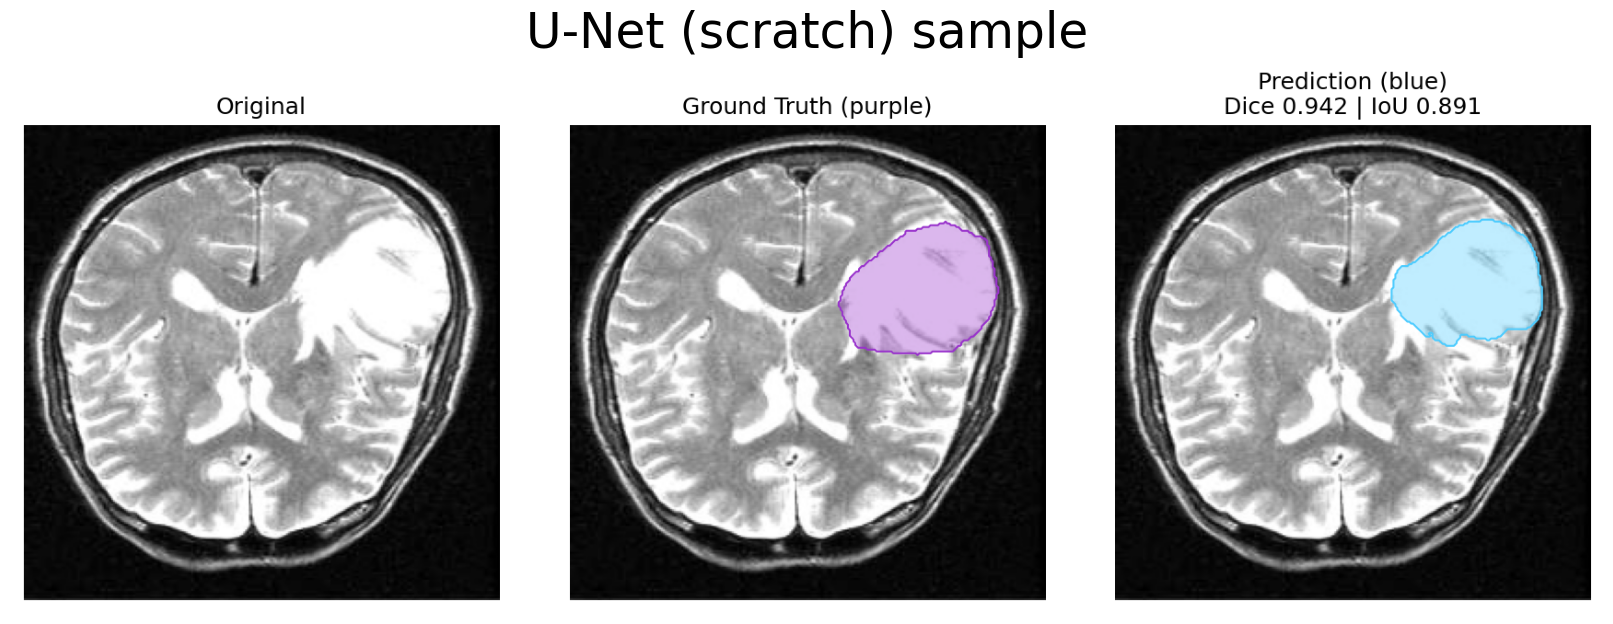

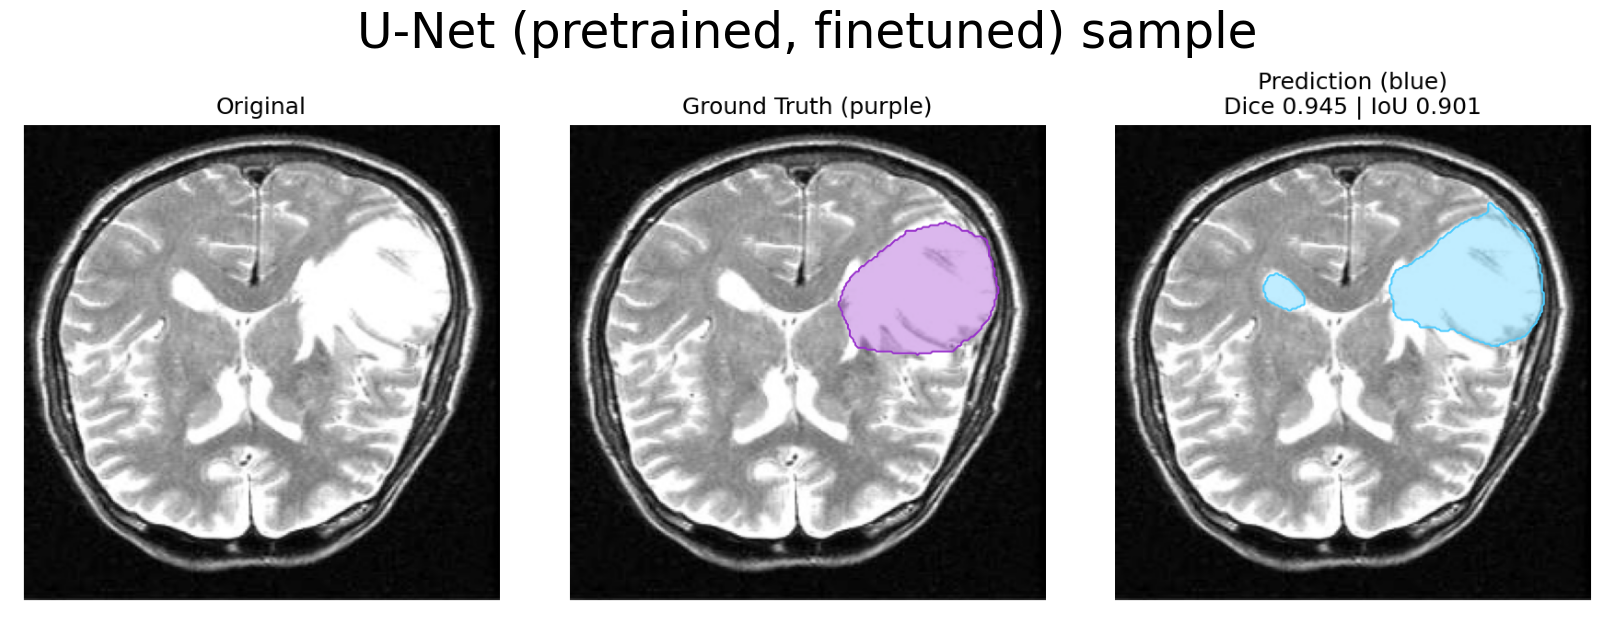

In [ ]:
def show_result_png(img_path, title=None, dpi=100, title_size=35):
    img_path = Path(img_path)
    if not img_path.exists():
        raise FileNotFoundError(f"Not found: {img_path}")
    im = Image.open(img_path)
    w, h = im.size
    plt.figure(figsize=(w/dpi, h/dpi), dpi=dpi)
    plt.imshow(im)
    if title:
        plt.title(title, fontsize=title_size)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

p1 = "reports/unet_base/unet_base_pred_002.png"
p2 = "reports/smp_finetune/smp_finetune_pred_002.png"

show_result_png(p1, "U-Net (scratch) sample")
show_result_png(p2, "U-Net (pretrained, finetuned) sample")

saved → reports\plots\unet_vs_smp.png


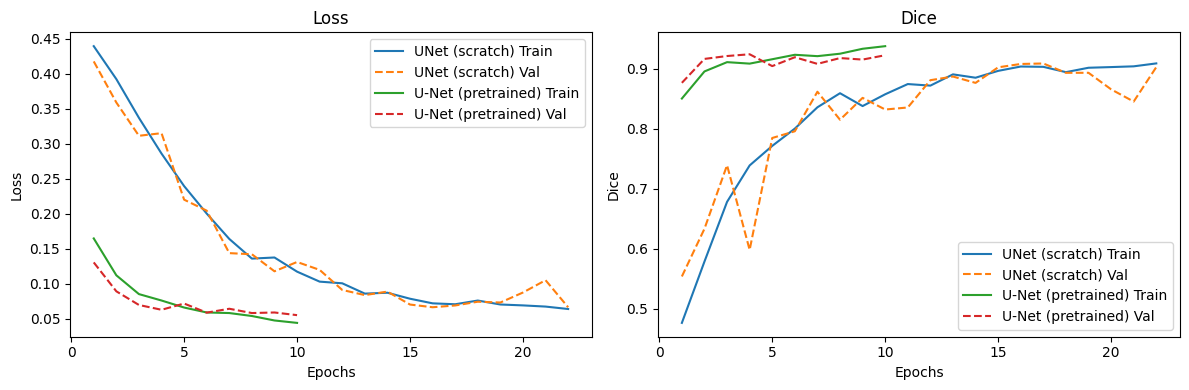

In [15]:
# compare both one plot
plot_histories(
    [
        "models/models_unet_base/training_metrics.json",
        "models/models_smp_finetune/training_metrics.json"
    ],
    labels=["UNet (scratch)", "U-Net (pretrained)"],
    save_dir="reports/plots",
    save_name="unet_vs_smp.png"
)

The scratch U-Net ended up stronger than the pretrained one. It converged more steadily and generalised better which also shows up in the overlays with fewer false positives. The pretrained model likely suffers from a domain gap. ImageNet features are tuned for RGB natural images (not 1-channel MRI) so it plateaus earlier and over-segments more often.